# Gold & Bitcoin

In [1]:
from data_engineering import *

Using TensorFlow backend.


# Objective
* Predict the value of Bitcoin using **LSTM**, **Gradient Boosting Regression**, and **Random Forest**
* Features include historical data that tracks the value of hisotrical **BTC, gold, S&P500**, and various associated metrics and transformed features. 

# Background

Gold is an important part of a diversified investment portfolio because its price increases in response to events that cause the value of paper investments, such as stocks and bonds, to decline. Although the price of gold can be volatile in the short term, it has always maintained its value over the long term. Through the years, it has served as a hedge against inflation and the erosion of major currencies, and thus is an investment well worth considering. In fact, many investors prefer gold for its freedom and privacy that delivers.

Bitcoin has been criticized as potential competitor for gold. With the leading cryptocurrency Bitcoin, the entire cryptocurrency market is to challenge and likely to affect both the gold and finance industry as well as the industries that support them.

We were interested in exploring possible underlying relationships between BTC and the value of gold.  To this end, we leveraged the value of gold and its associated metrics as features over time to predict the price of BTC in USD in the future.  Several machine-learning strategies were explored using a variety of feature-transformations and statistics. Below, we present the data collection, the creation of  three (3) different models from the `Keras/TensorFlow` library using different features, and review their respective prediction measures. 

# Model Creation

Below we outline the general steps taken to build the data and models for BTC prediction.  Only a selection of permutations and models that were run are included, and our intention is to illustrate, at least in part, the impact of feature inclusion across different model fitting strategies. 

## Data Preparation

Daily time series data was downloaded from three (3) primary sources and combined via python script (see `data_engineering.py` for details).  These sources include: 

* BTC in USD, BTC Vol. and cryptocurrency volume:  CryptoCompare API
* SPDR GLD ETF and selected metrics: SPDR Gold Website
* S&P500: Federal Reserve Bank of St. Louis

While BTC exchanges run 24x7, fiat-based securities (e.g. GLD ETF or S&P500) run on business days.  Aftering joining with the BTC data, all fiat-based features were forward-filled with their last values (e.g. over weekends/holidays).

As the USD value of BTC has been extremely volatile in the last couple of years, we settled on a timeframe that spans almost 5 years.  Our intention was to capture the wide-variety of changes to the value of BTC that have occured in that time which include several material swings in valuation. 

As stated previously, our intention was to leverage the value of gold as feature to predict the price of BTC in USD. Our model selection review examined several gold-related measures including gold market capitalization and the LMBA Gold price that SPDR uses to “reflect the performance of the price of gold bullion, less the Trust's expenses” for their GLD exchange-traded fund (ETF).  

Further, the inclusion of the S&P500 data provided candidate models with a well-known economic measure for the model-fitting procedures in `sklearn`’s RandomForestRegressor` and `GradientBoostingRegressor` package and whos inclusion generally resulted in more favorable prediction results. 

## Features

As with additional data sources, the decision to include feature statistics and additional calculated columns stemmed from model diagnostic reviews. Models that contained fewer features ran faster but produced poorer predictions.  

Inclusion of features such as rolling mean of GLD and BTC were included to give a vector for the model procedures to leverage.  Please review the accompanying `data_engineering.py` that contains all relevant code run for this project. 

Following feature addition, each team member attempted a model build based on a core data set with the following colunmns: 

In [2]:
core_data = get_combined_data()
print("*" * 75)
for i in range(round(len(core_data.columns.values) / 8) + 1):
    print(", ".join(core_data.columns.values[i * 8:(i + 1) * 8]))
print("*" * 75)

***************************************************************************
btc_close, btc_volume, GLD_close, LMBA_price, GLD_market_cap, SP500, crypto_volume, week
day, dayofweek_0, dayofweek_1, dayofweek_2, dayofweek_3, dayofweek_4, dayofweek_5, dayofweek_6
year_2015, year_2016, year_2017, year_2018, year_2019, year_2020, month_1, month_2
month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10
month_11, month_12, btc_close_roc, btc_volume_roc, crypto_volume_roc, gold_close_roc, lmba_gold_roc, gold_volume_roc
SP500_roc, gld_lr, gmc_lr, sp5_lr, crv_lr, btcMA3, btcMA5, btcMA10
btcMA20, gldMA2, gldMA5, gldMA10, gldMA20, btc_lr, btv_lr, btc_lg1p

***************************************************************************


In the feature output above, features ending with `_roc` indicate rate of change, `_lr` are the log returns, and `MAx` is moving average where `x` is window size in days. Dates were parsed from the time-index of the core data to include dummy variables with binary indication. The response variable, `btc_close`, was the primary focus but investigation into transformation of this value were also explored including: `btc_lr` and `btc_lg1p` the latter of which is `np.log(btc_close + 1)`.

Below, we review the top of the dataset as well as some plots of some features: 

In [3]:
core_data.head()

,btc_close,btc_volume,GLD_close,LMBA_price,GLD_market_cap,SP500,crypto_volume,week,day,dayofweek_0,...,btcMA5,btcMA10,btcMA20,gldMA2,gldMA5,gldMA10,gldMA20,btc_lr,btv_lr,btc_lg1p
date,,,,,,,,,,,,,,,,,,,,,
2015-04-19,223.02,7984589.44,115.60,1203.35,2.858641e+10,2081.18,29706194.86,16,19,0,...,223.982,226.855,238.7190,115.600,115.452,115.472,115.4020,-0.001479,-0.020803,5.411735
2015-04-20,224.24,10082693.46,114.72,1196.50,2.842270e+10,2100.40,32522083.32,17,20,1,...,224.236,225.806,237.7235,115.160,115.310,115.348,115.4550,0.005455,0.233307,5.417167
2015-04-21,233.73,15658818.31,115.38,1195.30,2.852002e+10,2097.29,43660268.49,17,21,0,...,225.386,225.531,237.0980,115.050,115.380,115.290,115.4440,0.041450,0.440214,5.458436
2015-04-22,233.78,18280060.34,113.83,1189.25,2.837531e+10,2107.96,63438905.50,17,22,0,...,227.624,225.324,236.1570,114.605,115.026,115.077,115.3715,0.000214,0.154777,5.458649
2015-04-23,235.40,9982620.64,114.66,1185.75,2.829147e+10,2112.93,45774695.23,17,23,0,...,230.034,226.505,235.2030,114.245,114.838,115.029,115.3405,0.006906,-0.604965,5.465525


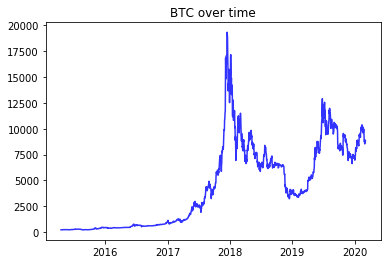

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(core_data.index, core_data.btc_close, c='b', label='BTC', alpha =.8)
plt.title('BTC over time')
plt.show()

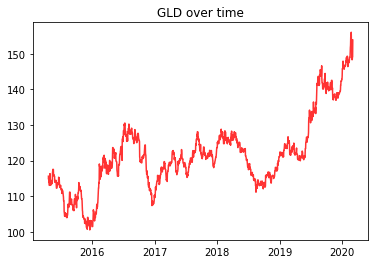

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(core_data.index, core_data.GLD_close, c='r', label='GLD', alpha =.8)
plt.title('GLD over time')
plt.show()

As shown above, the plots have appear to have wildly different patterns. It is unclear if there's any information in one plot that could be helpful in determining the other but we will show some information is valuable. 

## Models Explored

* LSTM
* Gradient Boosting Regressor
* Random Forest

In general, the model building process began with few features which were then added to based on performance metrics of the resulting model.  

### LSTM

LSTM is a type of recurrent neural network which use deep learning to predict sequences of values. An LSTM model is thus well-suited to time-series data. The model is an implementation of an LSTM using the Keras/TensorFlow library to predict Bitcoin prices.

The LSTM created predicts the price of the Bitcoin (BTC) cryptocurrency based on the prior values of BTC and Gold (GLD). For this, the LSTM  uses upto a maximum of 16 prior values of BTC and GLD to predict the next value of BTC. The parameter value of 16 is specified as the time window size when configuring the network. 

For training, the price history of BTC and GLD since 2013 are used to create a 3-dimensional array of values that are input to the LSTM. The 3 array dimensions store values for the timestamp, the currency prices and the size of the window used in the LSTM model. 

The LSTM model was created with 4 layers. The first layer is defined to have 512 neurons and 16 as the time window size. Linear activation and the "Adam" optimizer (which implements a stochastic gradient descent) were used. 

Shape of df is (1783, 2)
Training LSTM model for BTC
(1408, 16, 2) (1408, 1) (359, 16, 2) (359, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16, 512)           1054720   
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8193      
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,062,913
Trainable params: 1,062,913
Non-trainable params: 0
_________________________________________________________________
None
Train on 1408 samples, validate on 359 samples
Epoch 1/16
 - 18s - loss: 0.0702 - val_loss: 0.0845
Epoch 2/16
 - 17s - loss: 0.0451 - val_

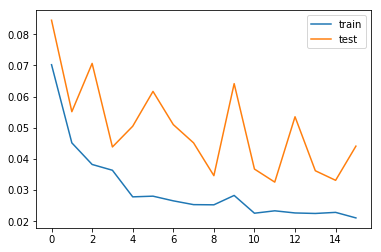

In [18]:
### LSTM Model ################################################################
data = prep_data(core_data, 'v')
lstm = run_lstm(data)

It is certainly possible that the LSTM model described above could be improved using using additional features.  This first model with only the bare-minimum features (lagged BTC value, GLD) provided a baseline and context from which to explore additional modelling strategies.  

### Gradient Boosting Regression

Gradient boosting regression is a machine-learning strategy that produces a prediction model made up of an ensemble of weaker prediction models.  Models are built in stages which allows for optimization of arbitrary differentiable loss functions and which makes them suitable for time-series data.  

Employing the `keras` package’s `GradientBoostingRegressor`, training procedures involves randomly permuted features at each split.  Several models were created and reviewed for this supervised learning strategy and one example is shown below. 

***************************************************************************
Modeling: btc_close
Features Include:
btc_volume, GLD_close, LMBA_price, GLD_market_cap, SP500, crypto_volume, btc_close_roc, btc_volume_roc, crypto_volume_roc, gold_close_roc
lmba_gold_roc, gold_volume_roc, SP500_roc, dayofweek_0, dayofweek_1, dayofweek_2, dayofweek_3, dayofweek_4, dayofweek_5, dayofweek_6
year_2015, year_2016, year_2017, year_2018, year_2019, year_2020

***************************************************************************
RMSLE CV Score: nan
RMSE Value: 1.90434


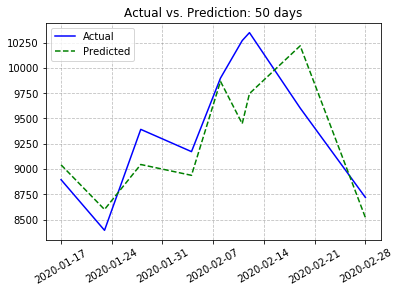

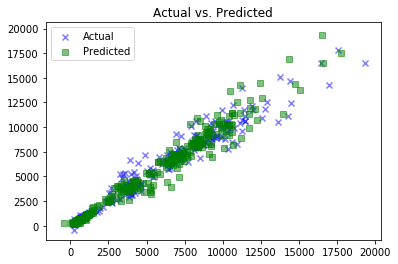

In [9]:
### GRADIENT BOOST REGR I #####################################################
data_a = prep_data(core_data, 'r')
label_name, feature_names = label_and_feat(data_a, 'r')
X_train, X_test, y_train, y_test = my_testTrain_split(data_a, feature_names,
                                                      label_name)
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01)
gbm.fit(X_train,y_train)
preds = gbm.predict(X= X_test)
mse = mean_squared_error(y_test, gbm.predict(X_test))
scores = my_crossval(gbm, X_train, y_train, "GradientBoostRegressI")
act_v_predict_plot(preds, y_test, 50)
pred_vs_act_sca(preds, y_test)

Above, we can see the model prediction has improved a great deal.  This is primarily due to the inclusion of many additional features.  If we review the variable importance for this model, we can see there is a strong influence from `SP500` although most influence stems from historical `btc_close_roc`. We were pleased to note that `GLD_market_cap` and `gold_volume_roc` play important roles in the prediction as well. 

Features sorted by importance to prediction: 

In [10]:
print(sorted(zip(map(lambda x: round(x, 4), gbm.feature_importances_),
                 feature_names), reverse=True))

[(0.695, 'SP500'), (0.1192, 'crypto_volume'), (0.0685, 'GLD_market_cap'), (0.0658, 'btc_volume'), (0.0158, 'LMBA_price'), (0.0087, 'GLD_close'), (0.0062, 'btc_close_roc'), (0.0058, 'year_2017'), (0.0032, 'btc_volume_roc'), (0.0024, 'year_2019'), (0.002, 'year_2018'), (0.0018, 'crypto_volume_roc'), (0.0016, 'SP500_roc'), (0.0013, 'gold_volume_roc'), (0.001, 'lmba_gold_roc'), (0.0009, 'gold_close_roc'), (0.0003, 'dayofweek_6'), (0.0002, 'year_2015'), (0.0002, 'dayofweek_5'), (0.0001, 'dayofweek_2'), (0.0001, 'dayofweek_1'), (0.0, 'year_2020'), (0.0, 'year_2016'), (0.0, 'dayofweek_4'), (0.0, 'dayofweek_3'), (0.0, 'dayofweek_0')]


As mentioned, we attempted several gradient boost models.  Below, we create another gradient boost regression with an alternative set of features that include rolling statistical measures for BTC, GLD, and SP500:

***************************************************************************
Modeling: btc_close
Features Include:
GLD_close, GLD_market_cap, SP500, crypto_volume, week, day, dayofweek_0, dayofweek_1, dayofweek_2, dayofweek_3
dayofweek_4, dayofweek_5, dayofweek_6, year_2015, year_2016, year_2017, year_2018, year_2019, year_2020, month_1
month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11
month_12, gld_lr, gmc_lr, sp5_lr, crv_lr, gldMA2, gldMA5, gldMA10, gldMA20, btcMA3
btcMA5, btcMA10, btcMA20
***************************************************************************
RMSLE CV Score: 0.05459
RMSE Value: 0.60138


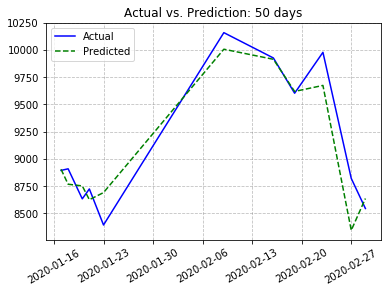

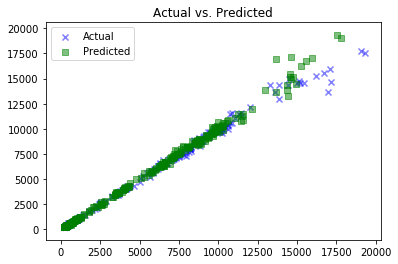

In [11]:
### GRADIENT BOOST REGR II #####################################################
data_a2 = prep_data(core_data, 'j')
label_name2, feature_names2 = label_and_feat(data_a2, 'j')
X_train2, X_test2, y_train2, y_test2 = my_testTrain_split(data_a2, feature_names2,
                                                      label_name2)
len(X_train.columns.values)
len(feature_names2)

gbm2 = GradientBoostingRegressor(n_estimators=4000,alpha=0.01)
gbm2.fit(X_train2,y_train2)
preds2 = gbm2.predict(X= X_test2)
mse = mean_squared_error(y_test2, gbm2.predict(X_test2))
scores = my_crossval(gbm2, X_train2, y_train2, "GradientBoostRegressII")
act_v_predict_plot(preds2, y_test2, 50)
pred_vs_act_sca(preds2, y_test2)

Above, the model results with the statistical features appears further improved.  RSMLE score is dramatically improved.   If we review the importance of the variables, we can see that `crv_lr` crypto volume log returns, and `crypto_volume` are influential followed by stats for historical BTC, and GLD. 

Features sorted by importance to prediction: 

In [12]:
print(sorted(zip(map(lambda z: round(z, 4), gbm2.feature_importances_),
                 feature_names2), reverse=True))

[(0.9663, 'btcMA3'), (0.0189, 'btcMA5'), (0.0077, 'btcMA20'), (0.0024, 'GLD_market_cap'), (0.0015, 'btcMA10'), (0.0009, 'gldMA20'), (0.0008, 'GLD_close'), (0.0003, 'gldMA10'), (0.0002, 'gmc_lr'), (0.0002, 'crypto_volume'), (0.0002, 'crv_lr'), (0.0002, 'SP500'), (0.0001, 'sp5_lr'), (0.0001, 'gld_lr'), (0.0001, 'gldMA5'), (0.0, 'year_2020'), (0.0, 'year_2019'), (0.0, 'year_2018'), (0.0, 'year_2017'), (0.0, 'year_2016'), (0.0, 'year_2015'), (0.0, 'week'), (0.0, 'month_9'), (0.0, 'month_8'), (0.0, 'month_7'), (0.0, 'month_6'), (0.0, 'month_5'), (0.0, 'month_4'), (0.0, 'month_3'), (0.0, 'month_2'), (0.0, 'month_12'), (0.0, 'month_11'), (0.0, 'month_10'), (0.0, 'month_1'), (0.0, 'gldMA2'), (0.0, 'dayofweek_6'), (0.0, 'dayofweek_5'), (0.0, 'dayofweek_4'), (0.0, 'dayofweek_3'), (0.0, 'dayofweek_2'), (0.0, 'dayofweek_1'), (0.0, 'dayofweek_0'), (0.0, 'day')]


### Random Forest Regression

Similar to gradient boosting regression, random forests (also know as random decision forests) is an ensemble learning method for regression.  Models are made up of numerous decision trees that provide a mean predictions based on trained feature-input.  Given the ensemble nature of the model, multiple learning algorithms are employed to obtain superior predictive performance.  Further, it is robust with respect to time-series data and is also well-suited for various data-types, as well as mixed transformed and untransformed data. 

The Random forest model in `keras` provides options for measuring variable importance with respect to prediction quality.  During model assessment, various features and respective transformations were added or removed depending on the the feature importance measures. 

The general procedure for Random Forest was to use normally distributed randomly generated values for parameters for max-depth and max-features for a number of tries. Once complete, the parameters from the first pass models are used to create a refined range for random parameter selection in a refined model.  Below, we utilize the same features as gradient boost regression I.  The model is trained using 10 different parameter inputs and then refined with an additional 5 repitions under a new range of parameters:  


In [13]:
### Random Forest Model I #####################################################
data_r = prep_data(core_data, 'r')
label_name3, feature_names3 = label_and_feat(data_r, 'r')
X_train3, X_test3, y_train3, y_test3 = my_testTrain_split(data_r, 
                                                          feature_names3,
                                                          label_name3)

fst_pass = my_randomForest(X_train3, y_train3) # 10 epochs is default
mnmxd, mxmxd, mnmxft, mxmxft = get_minmax_params(fst_pass) # refined params
refined = my_randomForest(X_train3, y_train3,
                           mnmxd, mxmxd, mnmxft, mxmxft, 5)
refined = refined.iloc[refined.score.idxmin(), :] #obtain min score
rfm = fit_RF(3000,refined.max_depth,refined.max_features, X_train3, y_train3)
scores = my_crossval(rfm, X_train3, y_train3, "r-forrest")

***************************************************************************
Modeling: btc_close
Features Include:
btc_volume, GLD_close, LMBA_price, GLD_market_cap, SP500, crypto_volume, btc_close_roc, btc_volume_roc, crypto_volume_roc, gold_close_roc
lmba_gold_roc, gold_volume_roc, SP500_roc, dayofweek_0, dayofweek_1, dayofweek_2, dayofweek_3, dayofweek_4, dayofweek_5, dayofweek_6
year_2015, year_2016, year_2017, year_2018, year_2019, year_2020

***************************************************************************
max_depth = 23, max_features = 0.498119, score = 0.11613
max_depth = 26, max_features = 0.476440, score = 0.11617
max_depth = 76, max_features = 0.944526, score = 0.10588
max_depth = 43, max_features = 0.906813, score = 0.10594
max_depth = 66, max_features = 0.694146, score = 0.10831
max_depth = 17, max_features = 0.979097, score = 0.10620
max_depth = 99, max_features = 0.644492, score = 0.10897
max_depth = 21, max_features = 0.433597, score = 0.11705
max_depth = 17, m

The procedure for random forest includes an output providing the scores of each model that's created for both the 10-attempt first pass, and the 5-attempt refinement.  We again review the actual vs. predicted plots to see how the model fit looks: 

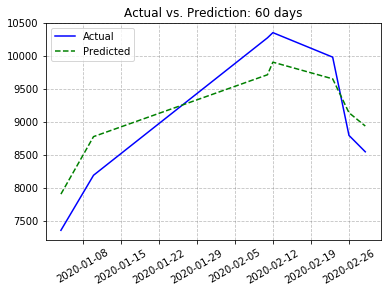

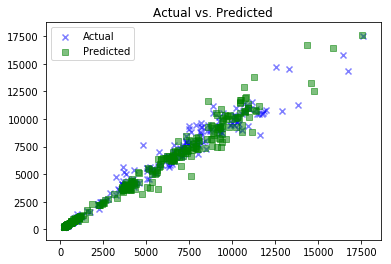

In [14]:
rfm_preds = rfm.predict(X_test3)
act_v_predict_plot(rfm_preds, y_test3, 60)
pred_vs_act_sca(rfm_preds, y_test3)

Again we see a bit of variance in the plots.  Below, we provide another random forest fit and our final model using the same features as gradient boost II.  Further, we've increased the first-pass parameter scoring to 15 random attempts.  Compute time can become extremely lengthy for many random attempts. 

In [15]:
### Random Forest Model II ####################################################
data_a2 = prep_data(core_data, 'j')
label_name2, feature_names2 = label_and_feat(data_a2, 'j')
X_train2, X_test2, y_train2, y_test2 = my_testTrain_split(data_a2, feature_names2,
                                                      label_name2)

fst_pass2 = my_randomForest(X_train2, y_train2, eps = 15) 
mnmxd, mxmxd, mnmxft, mxmxft = get_minmax_params(fst_pass2) # refined params
refined2 = my_randomForest(X_train2, y_train2,
                           mnmxd, mxmxd, mnmxft, mxmxft, 5)
refined2 = refined2.iloc[refined2.score.idxmin(), :] #obtain min score
rfm2 = fit_RF(3000,refined2.max_depth,refined2.max_features, X_train2, y_train2)
scores = my_crossval(rfm2, X_train2, y_train2, "r-forrest ii")

***************************************************************************
Modeling: btc_close
Features Include:
GLD_close, GLD_market_cap, SP500, crypto_volume, week, day, dayofweek_0, dayofweek_1, dayofweek_2, dayofweek_3
dayofweek_4, dayofweek_5, dayofweek_6, year_2015, year_2016, year_2017, year_2018, year_2019, year_2020, month_1
month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11
month_12, gld_lr, gmc_lr, sp5_lr, crv_lr, gldMA2, gldMA5, gldMA10, gldMA20, btcMA3
btcMA5, btcMA10, btcMA20
***************************************************************************
max_depth = 11, max_features = 0.753751, score = 0.03215
max_depth = 99, max_features = 0.368543, score = 0.03293
max_depth = 87, max_features = 0.155628, score = 0.04018
max_depth = 16, max_features = 0.245816, score = 0.03474
max_depth = 51, max_features = 0.323490, score = 0.03352
max_depth = 16, max_features = 0.645583, score = 0.03210
max_depth = 5, max_features = 0.948570, score

We have an improved RMSLE value, and below, the plots indicate an improved fit.   Note that the plot time-frame is 100 days and that the prediction appears to track the volatility decently. 

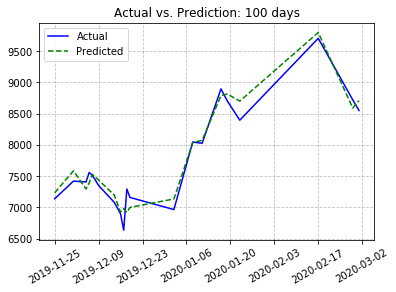

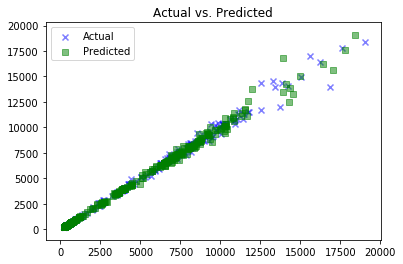

In [16]:
act_v_predict_plot(rfm2.predict(X_test2), y_test2, 100)
pred_vs_act_sca(rfm2.predict(X_test2), y_test2)

# Conclusion

While none of the models performed astonishingly well, the ensemble strategies appeared to perform best. We were successful in leveraging the included GLD features to predict values of BTC with a RMSE of about 5% - relatively close given intense volatility in the value of BTC in the past 5 years. The final model is able to predict 1 day in advance given the features under use.

The relative ease at which different models can be created provides a multitude of opportunities to delve deeper into the feature-importance and prediction quality information.  Further, the included python code in `data_engineering.py` provides flexibility for future use and enhancement.  There certainly additional data sources that could yield finer prediction. Finally, there are several additional package options that provide enhanced parameter-selection methods that have not yet been explored and have the possibility of improving prediction results and performance overall. 

### Reference and Sources:

* [SPDR Gold Shares Fact Sheet](http://www.spdrgoldshares.com/media/GLD/file/ETF-GLD_20171231.pdf)
* [Selecting Features for RandomForrest, datadive.net](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
* [LMBA Gold Price](http://www.lbma.org.uk/lbma-gold-price)
* [Diving Into Data: Selecting Good Features](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
* [Colah's Blog: Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Machine Learning Mastery: Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
* [David Sheehan Blog: Predicting Cryptocurrency Prices With Deep Learning](https://dashee87.github.io/deep%20learning/python/predicting-cryptocurrency-prices-with-deep-learning/)
* [sklearn.ensemble](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Wikipedia: SPDR ETFs](https://en.wikipedia.org/wiki/SPDR)
* [Wikipedia: Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
* [Wikipedia: Random Forest](https://en.wikipedia.org/wiki/Random_forest)
* [Wikipedia: Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning)
* [Wikipedia: Long short-term memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory)